In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import griddata

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
az.style.use('arviz-darkgrid')

#### Code 4.1

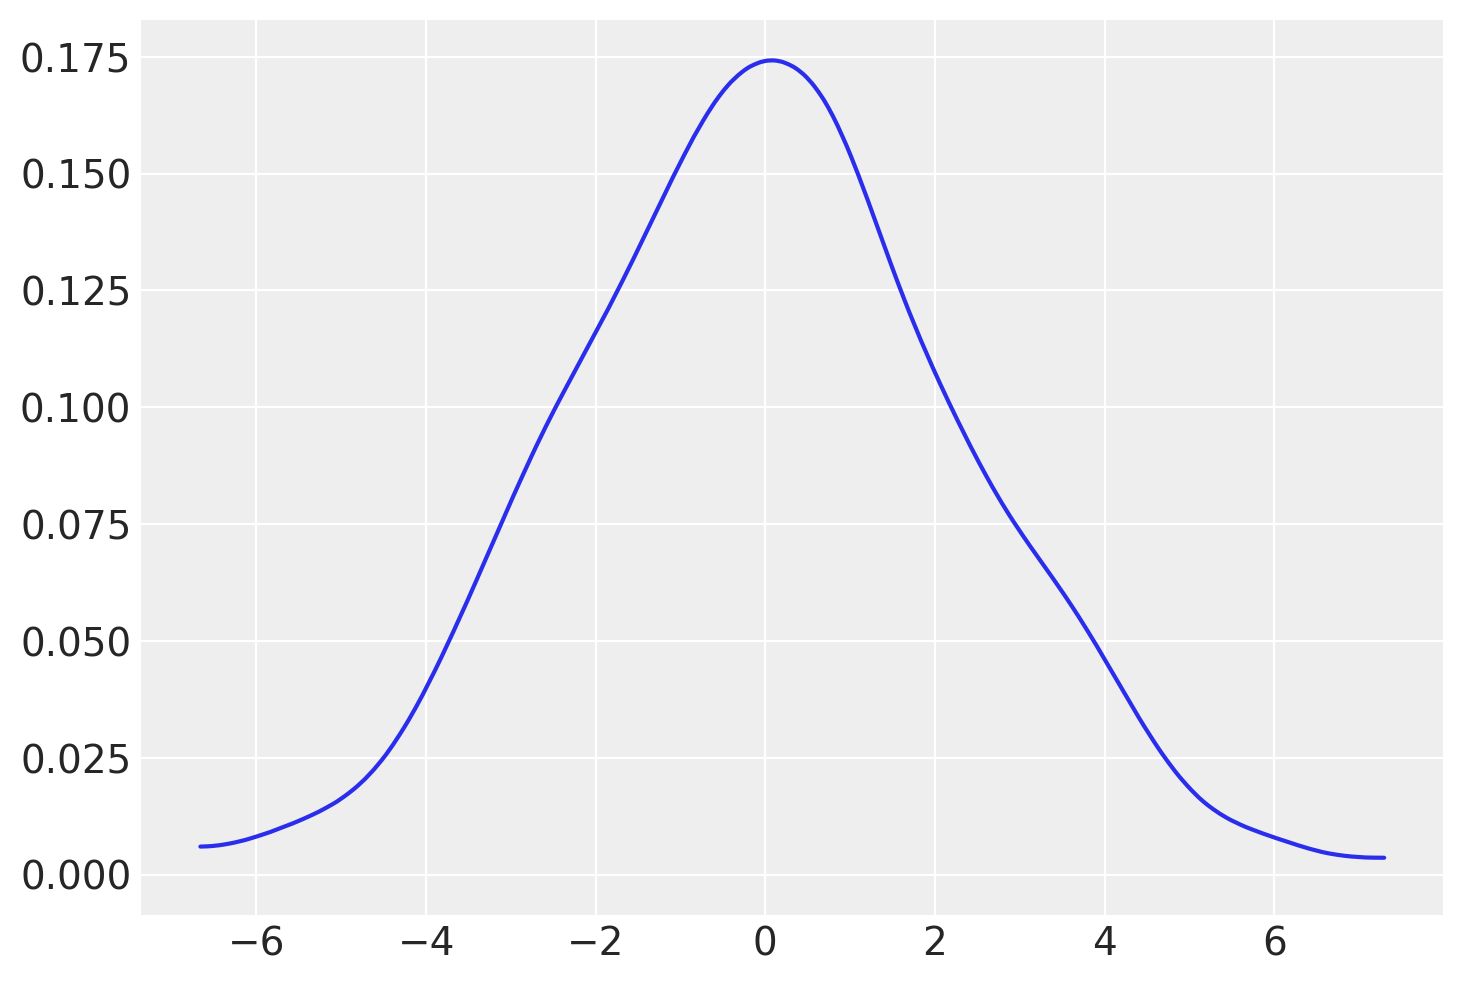

In [3]:
pos = np.random.uniform(-1, 1, size=(16, 1000)).sum(0)
az.plot_kde(pos);

#### Code 4.2 and 4.3

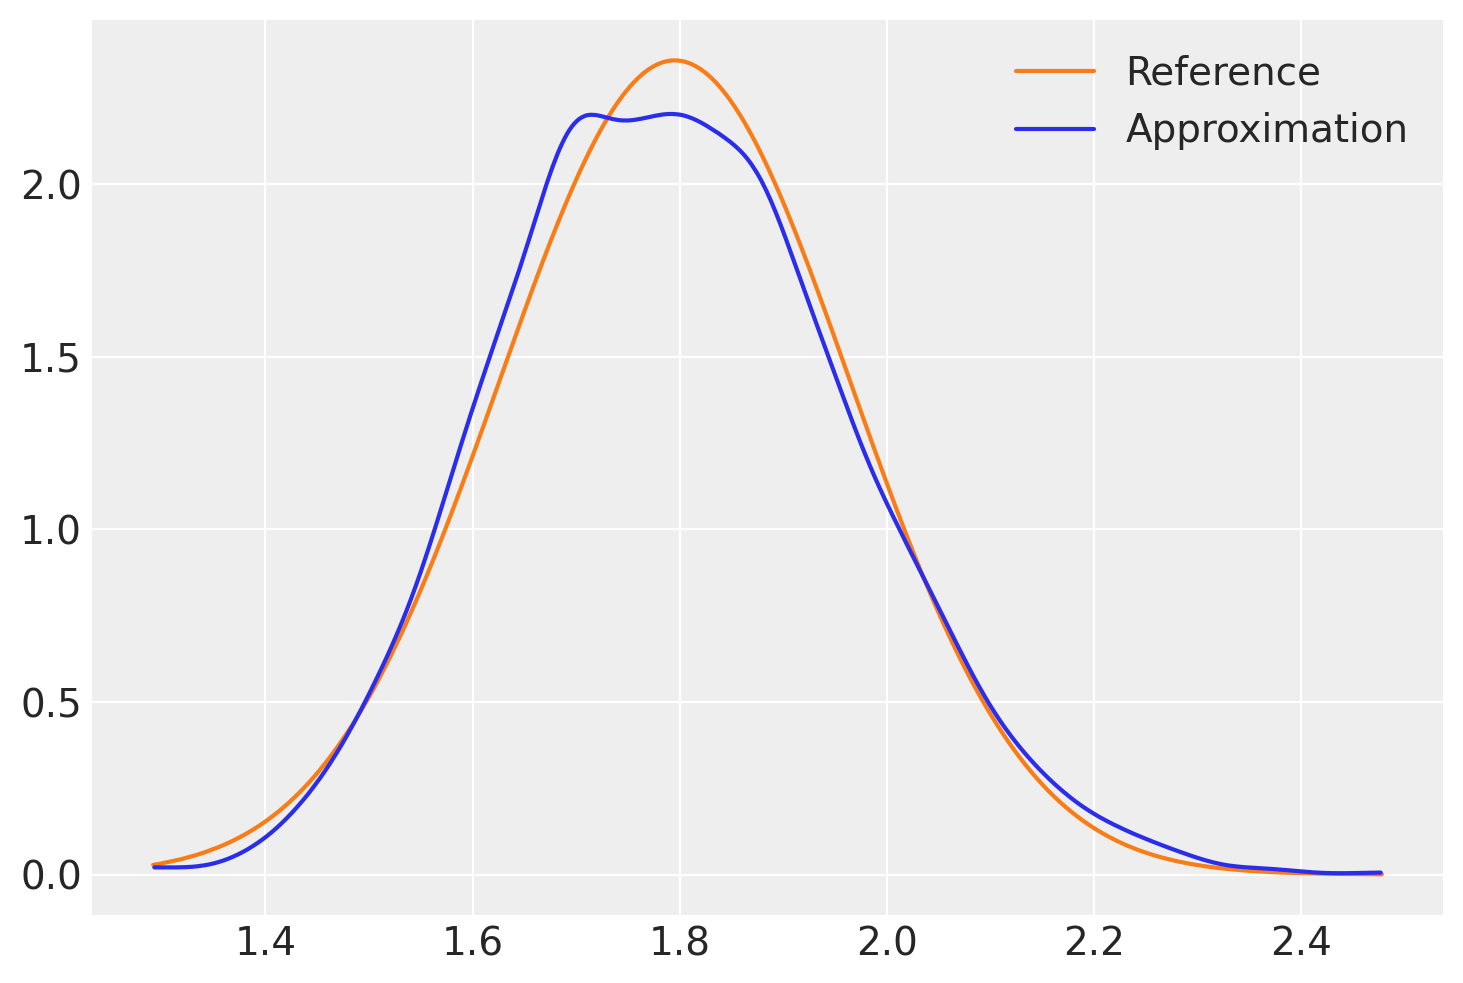

In [4]:
pos = np.random.uniform(1, 1.1, size=(12, 10000)).prod(0)
pos_sorted = np.sort(pos)
reference_normal_pdf = stats.norm.pdf(x=pos_sorted, loc=pos.mean(), scale=pos.std())
plt.plot(pos_sorted, reference_normal_pdf, color="C1", label="Reference")
az.plot_kde(pos, label="Approximation")
plt.legend(loc=0);

#### Code 4.4

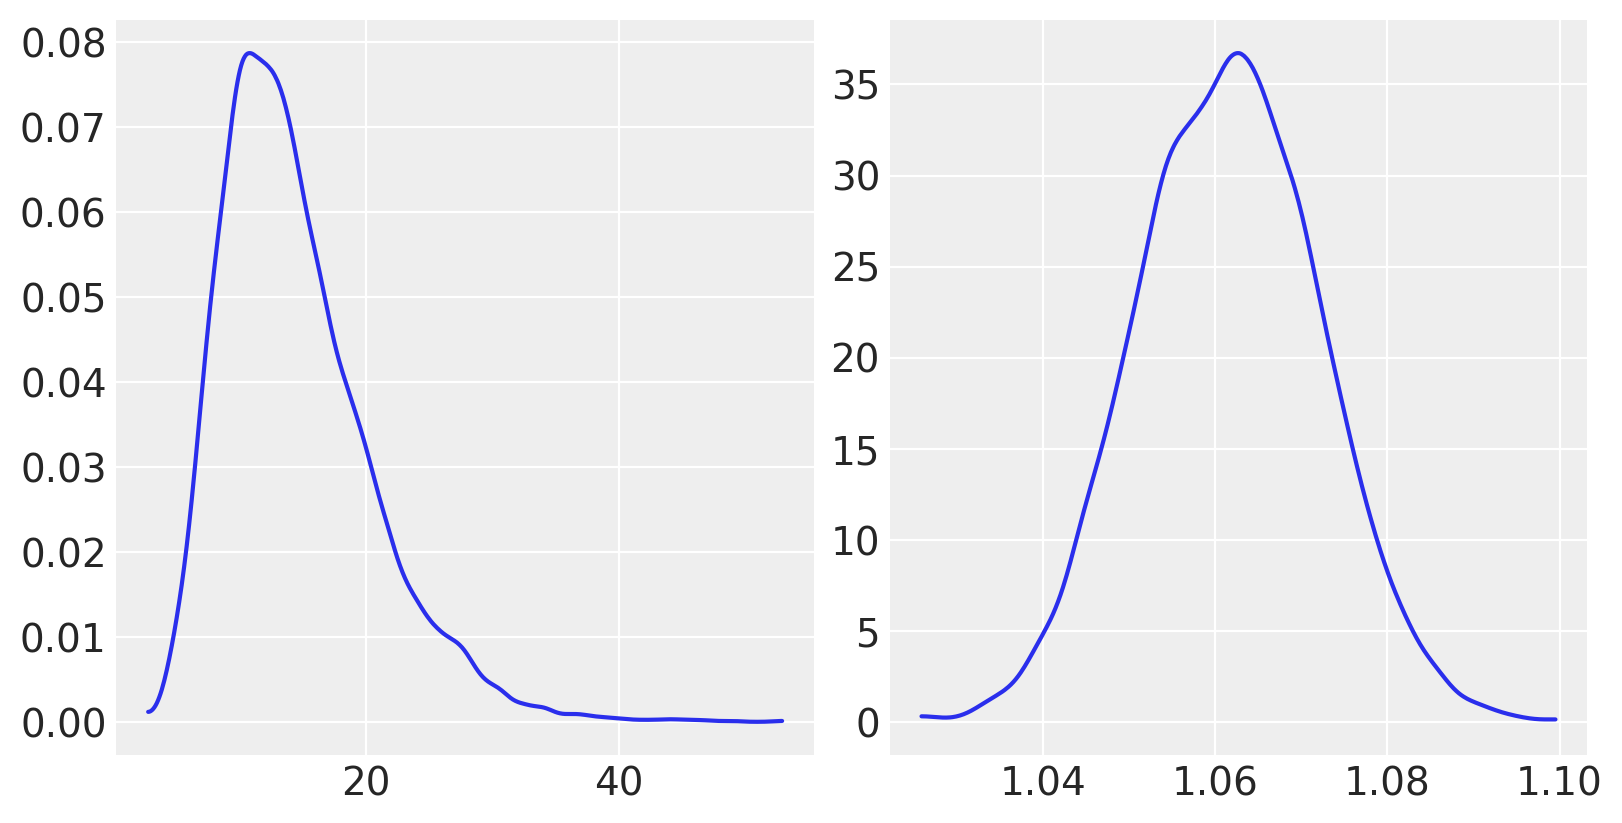

In [5]:
big = np.random.uniform(1, 1.5, size=(12, 10000)).prod(0)
small = np.random.uniform(1, 1.01, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_kde(big, ax=ax[0])
az.plot_kde(small, ax=ax[1]);

#### Code 4.5

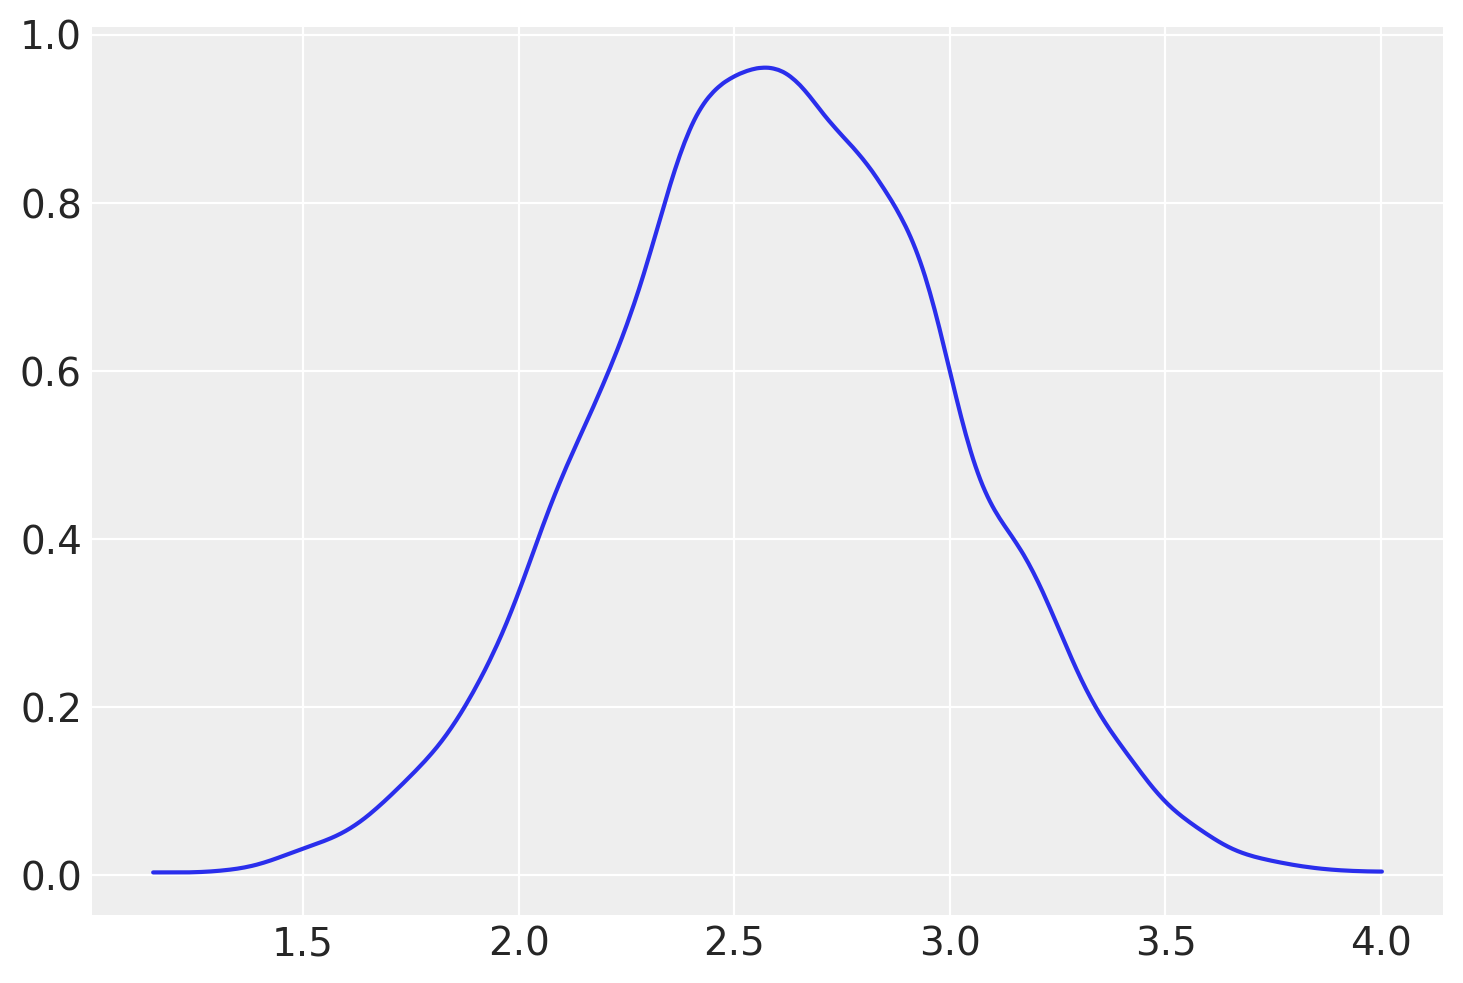

In [6]:
log_big = np.log(np.random.uniform(1, 1.5, size=(12, 10000)).prod(0))
az.plot_kde(log_big);

#### Code 4.6

We are going to use the same function we use on chapter 2 (code 2.3)

In [7]:
def posterior_grid_approx(grid_points=100, success=6, tosses=9):
    """
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = np.repeat(5, grid_points)  # uniform
    # prior = (p_grid >= 0.5).astype(int)  # truncated
    # prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

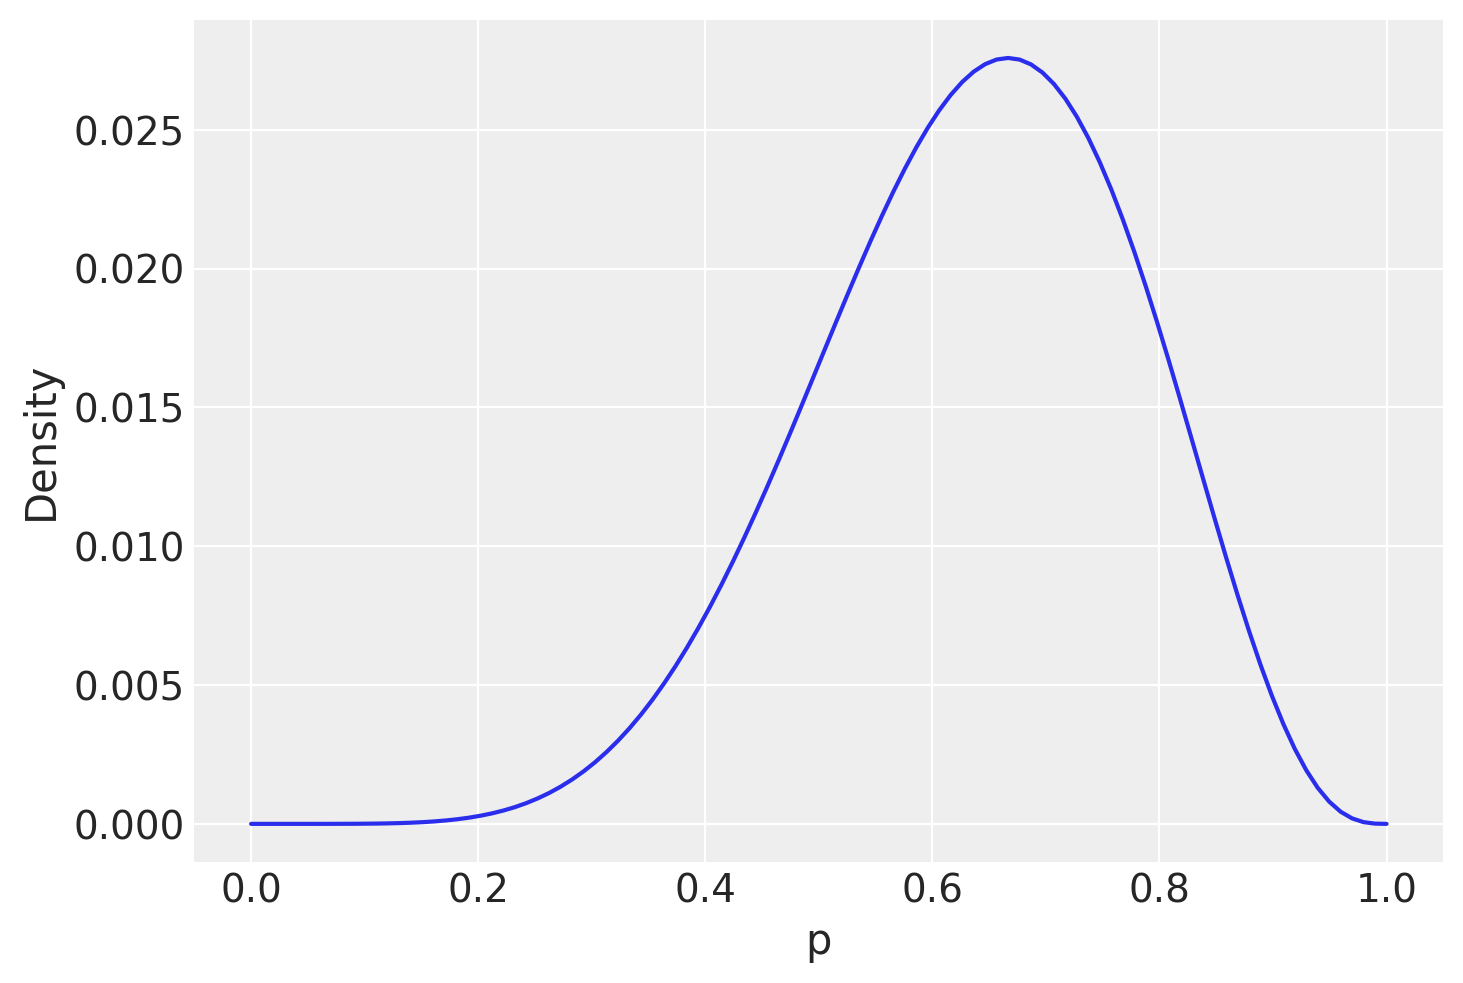

In [8]:
p_grid, posterior = posterior_grid_approx(grid_points=100, success=6, tosses=9)
plt.plot(p_grid, posterior)
plt.xlabel('p')
plt.ylabel('Density');

#### Code 4.7 and 4.8

Datasets are located in the 'data' folder.

In [9]:
d = pd.read_csv('data/Howell1.csv')
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


#### Code 4.9

In [10]:
d.describe(percentiles=[0.055, 0.945], )

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
5.5%,81.108550,9.360721,1.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
94.5%,165.735000,54.502894,66.135000,1.000000
max,179.070000,62.992589,88.000000,1.000000


#### Code 4.10

In [11]:
d.height # or d['height']

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

#### Code 4.11

In [12]:
d2 = d[d.age >= 18]

#### Code 4.12

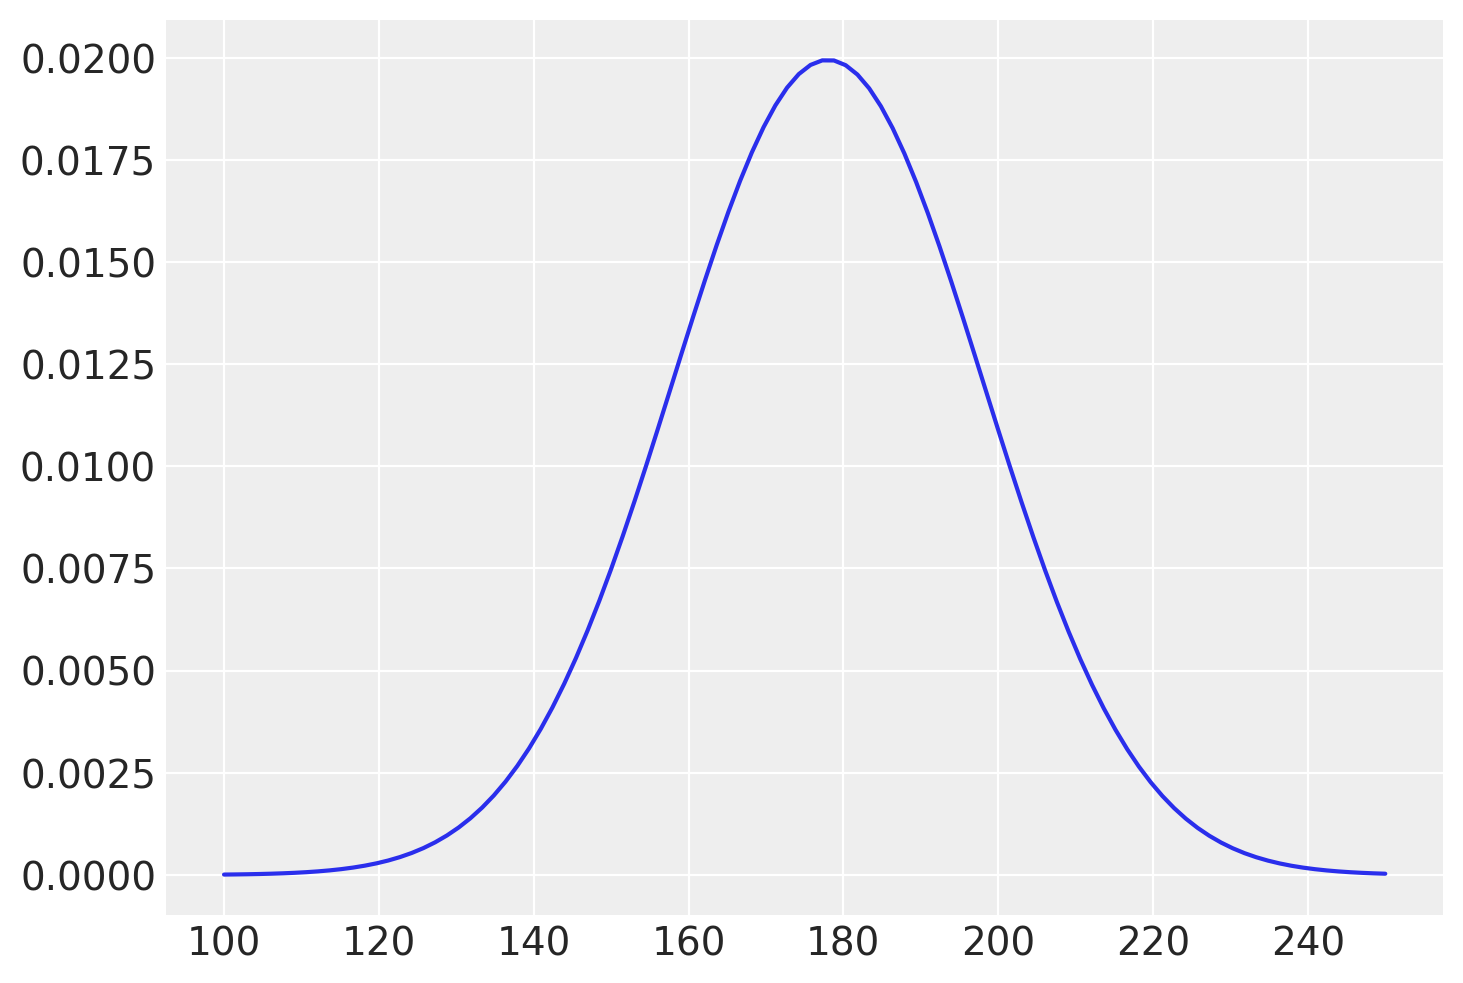

In [13]:
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20));

#### Code 4.13

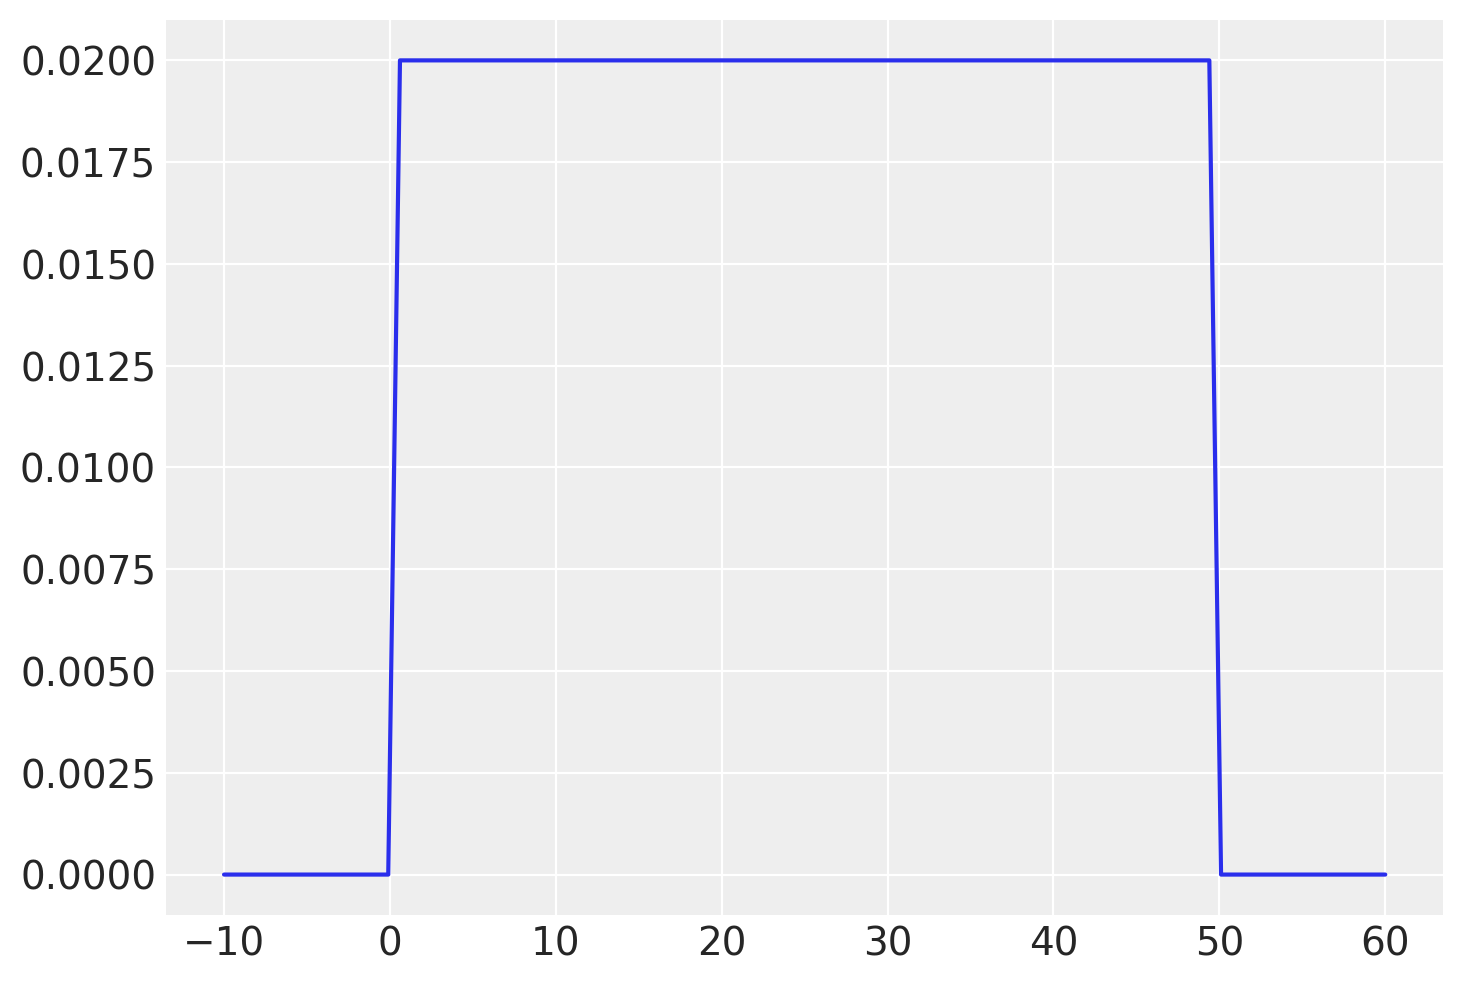

In [14]:
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50));

#### Code 4.14

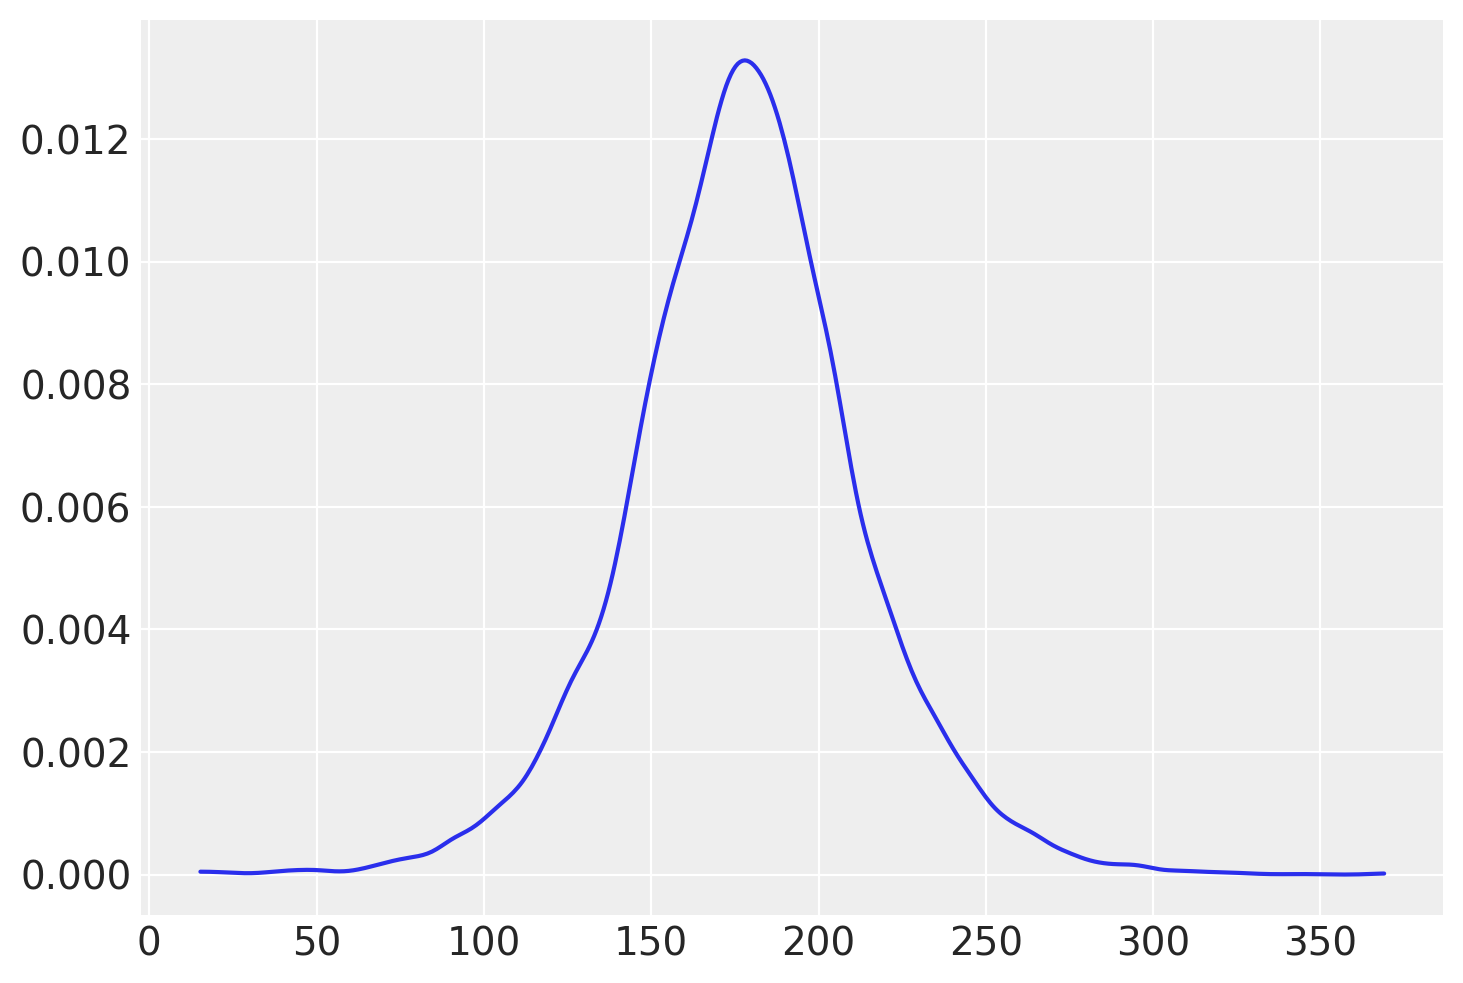

In [15]:
n = int(1e4)
sample_mu = stats.norm.rvs(178, 20, size=n)
sample_sigma = stats.uniform.rvs(0, 50, size=n)
prior_h = stats.norm.rvs(sample_mu, sample_sigma) # size is not required

az.plot_kde(prior_h);

#### Code 4.15

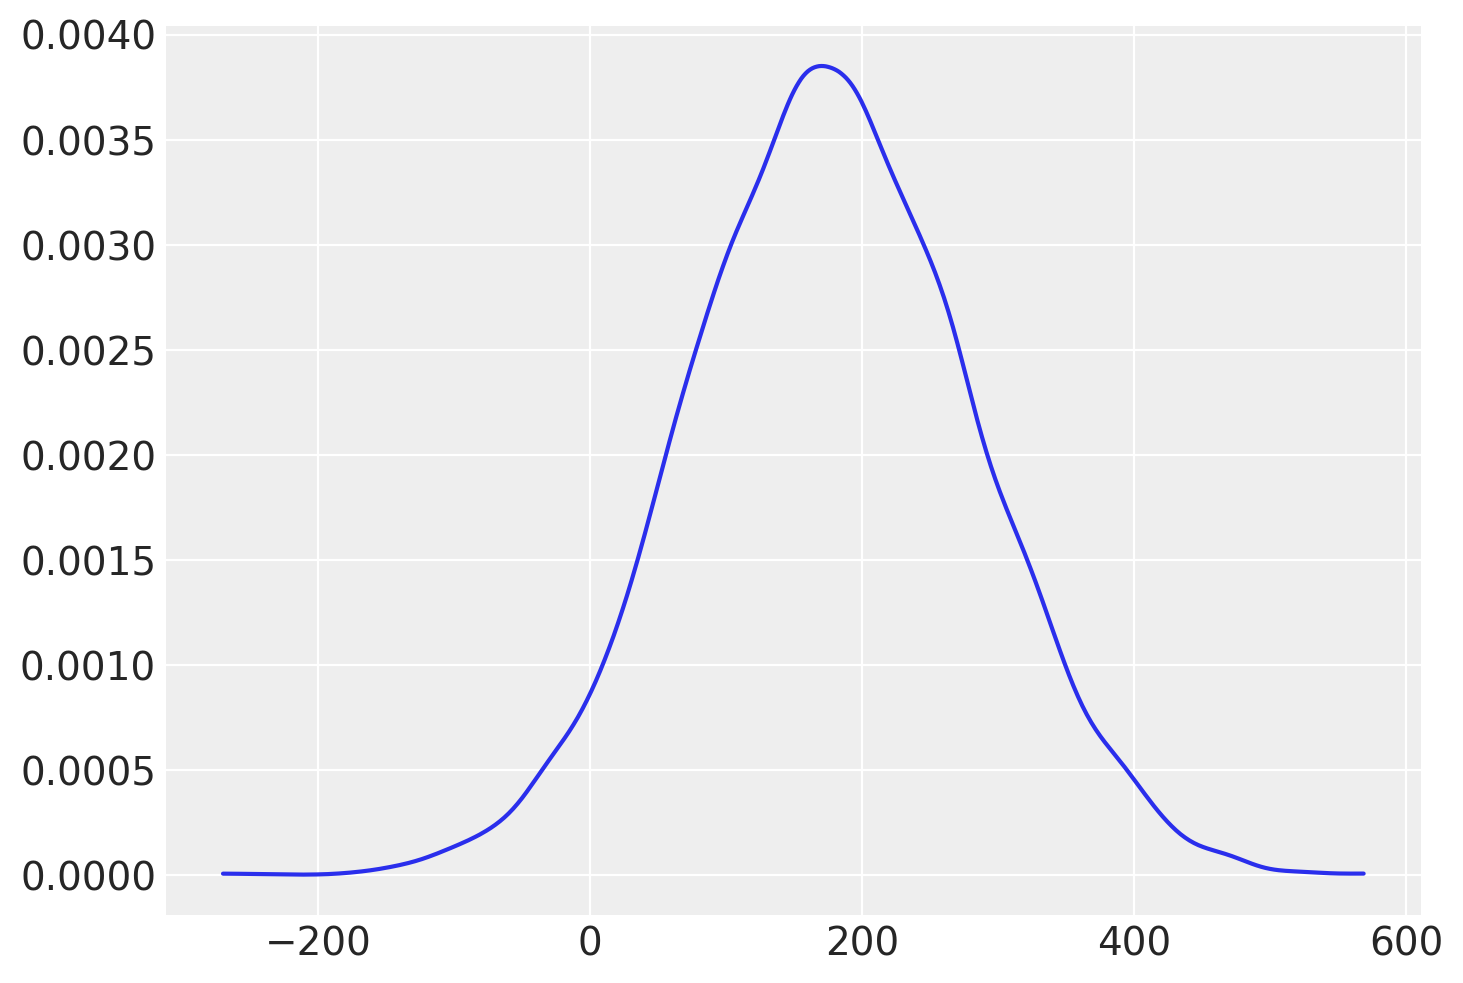

In [16]:
n = int(1e4)
sample_mu = stats.norm.rvs(178, 100, size=n)
prior_h = stats.norm.rvs(sample_mu, sample_sigma)
az.plot_kde(prior_h);

#### Code 4.16

In [17]:
mu_list = np.linspace(150, 160, num=100)
sigma_list = np.linspace(7, 9, num=100)
post = pd.DataFrame(np.array(np.meshgrid(mu_list, sigma_list)).reshape(2,-1).T, columns=["mu", "sigma"])
post['LL'] = [
    stats.norm.logpdf(d2.height, loc=post.mu[i], scale=post.sigma[i]).sum() 
    for i in post.index
]
post['prod'] = post.LL + stats.norm.logpdf(post.mu, loc=178, scale=20) + stats.uniform.logpdf(post.sigma, 0, 50)
post['prob'] = np.exp(post['prod'] - post['prod'].max())

#### Code 4.17

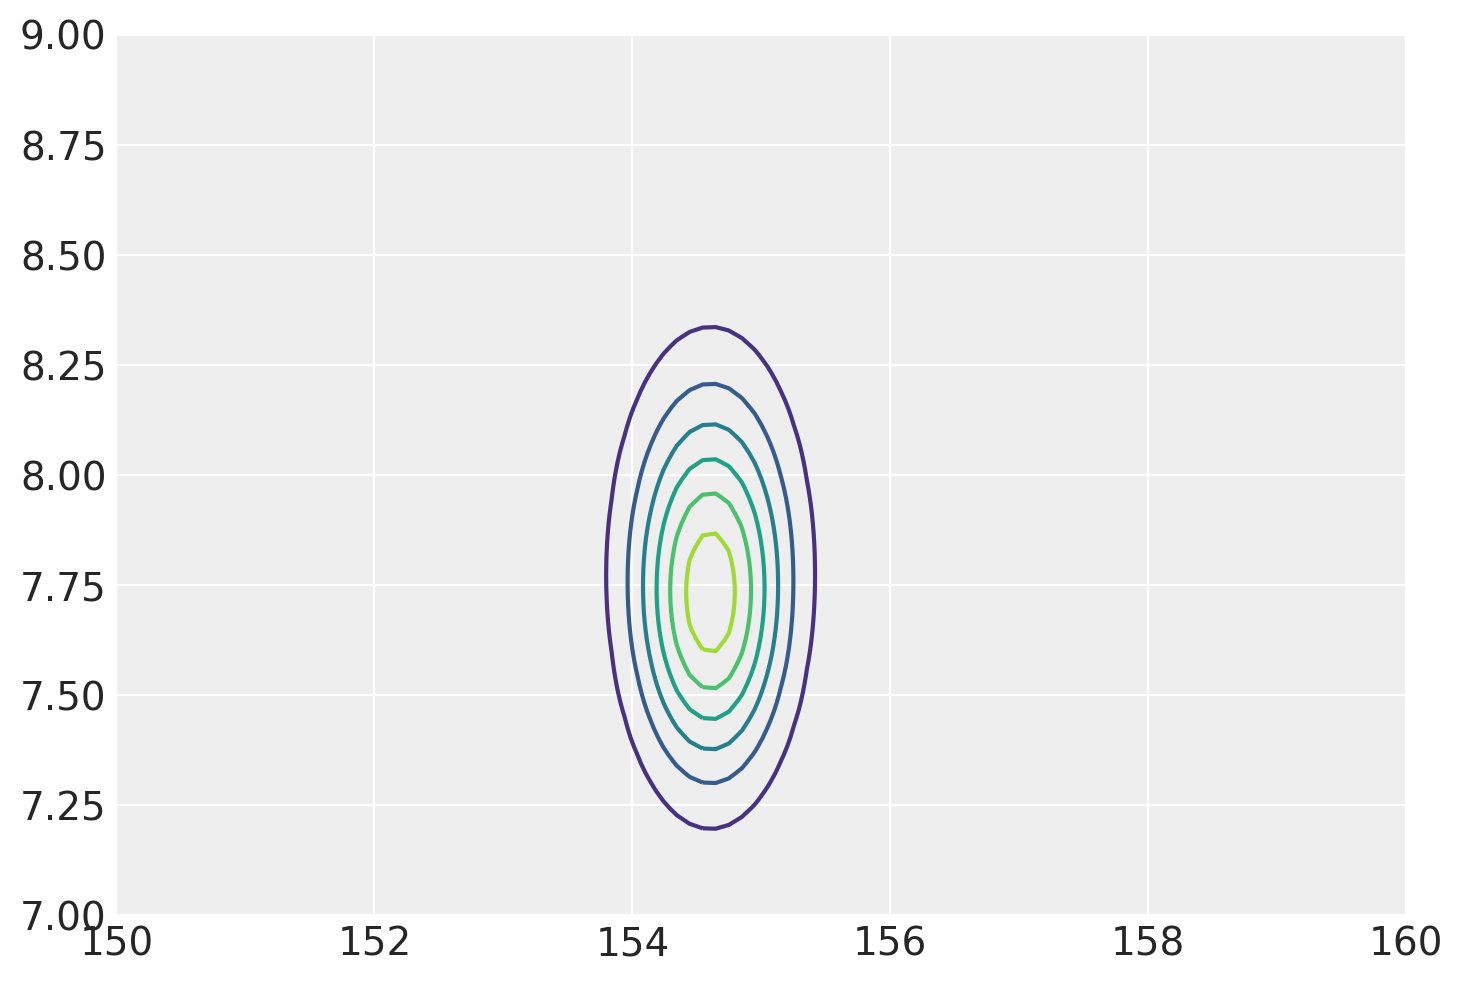

In [18]:
xi = np.linspace(post['mu'].min(), post['mu'].max(), 100)
yi = np.linspace(post['sigma'].min(), post['sigma'].max(), 100)
zi = griddata((post['mu'], post['sigma']), post['prob'] , (xi[None,:], yi[:,None]))

plt.contour(xi, yi, zi);

#### Code 4.18

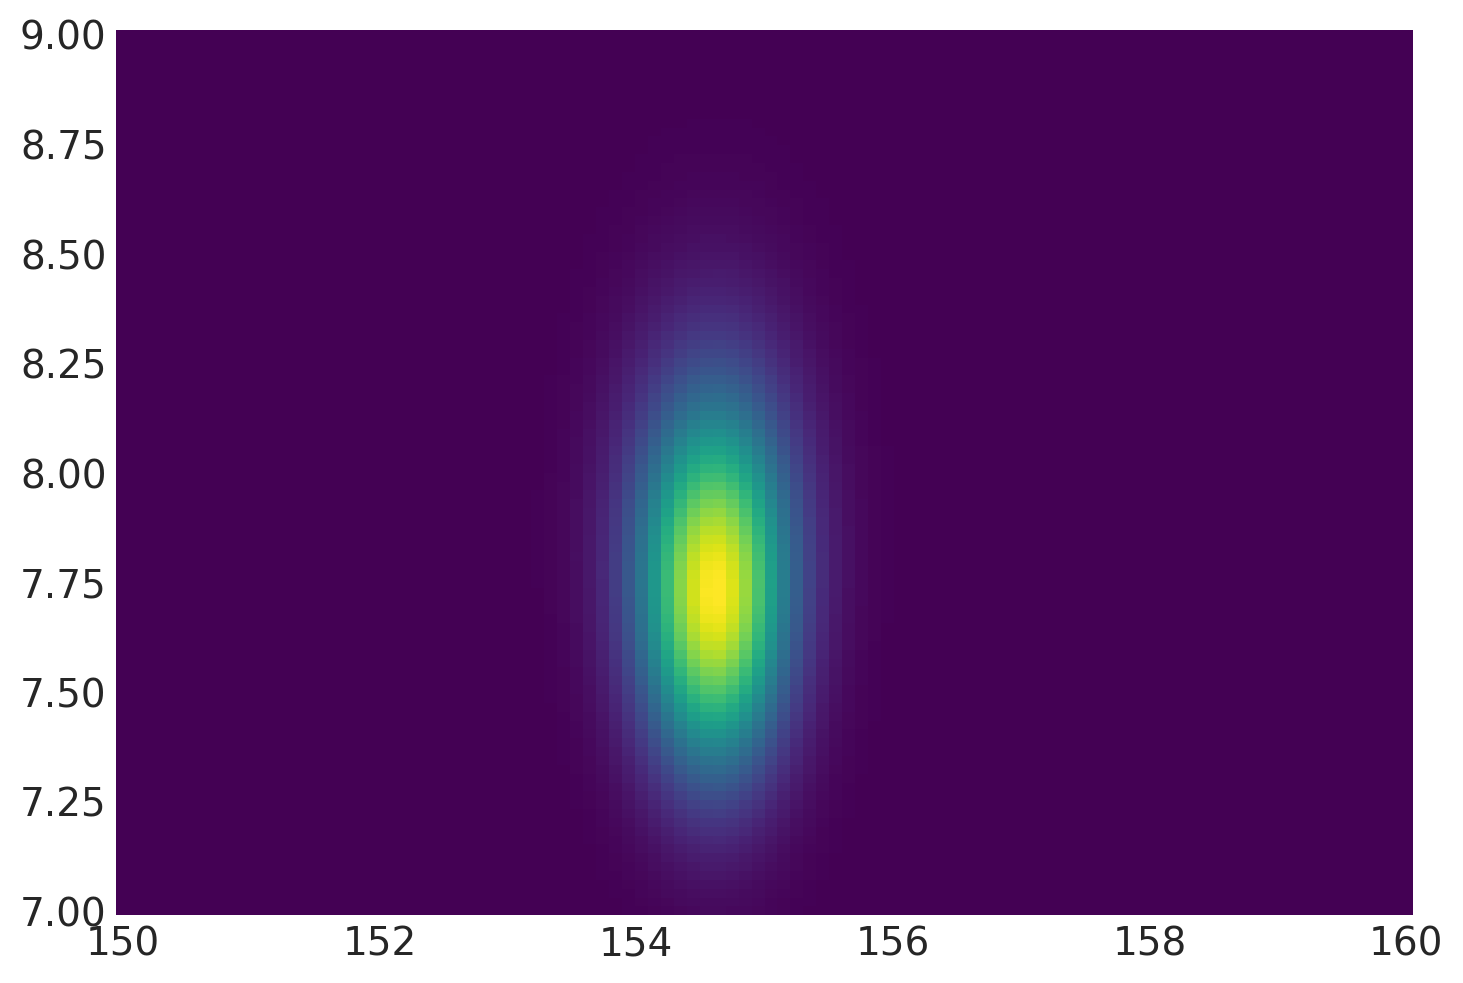

In [19]:
plt.pcolormesh(xi, yi, zi, shading='auto');